<a href="https://colab.research.google.com/github/uplus26e7/pytorch-programming-introduction/blob/master/%E5%8B%95%E3%81%8B%E3%81%97%E3%81%AA%E3%81%8C%E3%82%89%E5%AD%A6%E3%81%B6_PyTorch_%E3%83%97%E3%83%AD%E3%82%B0%E3%83%A9%E3%83%9F%E3%83%B3%E3%82%B0%E5%85%A5%E9%96%80_Chapter5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim

# Section 2 株価予測【サンプルコード】

## Section 2.1 訓練データとテストデータの用意

In [46]:
dataset = pd.read_csv("prices.csv")
dataset.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [47]:
symbols = list(set(dataset.symbol))
print(len(symbols))
print(symbols)

501
['TDG', 'CBS', 'LLTC', 'XRX', 'PG', 'CTAS', 'SWKS', 'ADBE', 'UDR', 'LKQ', 'PCAR', 'DD', 'LNT', 'D', 'SCHW', 'ZTS', 'CTXS', 'COH', 'VZ', 'MPC', 'FITB', 'RAI', 'HES', 'SRCL', 'TDC', 'MNK', 'LVLT', 'DIS', 'SYK', 'PVH', 'HAR', 'NBL', 'INTC', 'NRG', 'EIX', 'ROK', 'PAYX', 'WAT', 'PLD', 'EOG', 'AIZ', 'LNC', 'XOM', 'ITW', 'DG', 'FFIV', 'KORS', 'APD', 'GD', 'ARNC', 'SYY', 'REGN', 'DVA', 'NEE', 'RCL', 'COTY', 'HRL', 'PXD', 'FTV', 'JEC', 'DLR', 'NOC', 'STI', 'ABC', 'EBAY', 'PNW', 'DGX', 'GWW', 'PPL', 'PRU', 'BWA', 'MU', 'IVZ', 'CMA', 'FCX', 'EA', 'UPS', 'MCHP', 'LYB', 'LH', 'DHR', 'MMM', 'XL', 'BEN', 'HAS', 'SO', 'GOOG', 'ALLE', 'MTD', 'IFF', 'WDC', 'KLAC', 'MJN', 'K', 'URI', 'SNI', 'SIG', 'EQT', 'OXY', 'BMY', 'LRCX', 'CA', 'DISCA', 'HD', 'QRVO', 'MAT', 'SHW', 'IDXX', 'OMC', 'DISCK', 'IP', 'MTB', 'WMT', 'GPS', 'MSFT', 'PFE', 'NAVI', 'ALL', 'UTX', 'COP', 'MRO', 'FBHS', 'AAP', 'CERN', 'ED', 'SPG', 'A', 'SNA', 'AN', 'CSX', 'QCOM', 'COG', 'LLL', 'IR', 'DTE', 'SYF', 'AMAT', 'AWK', 'BAX', 'EQR', 'B

In [48]:
dataset = dataset[dataset["symbol"] == "YHOO"]
dataset.head()

,date,symbol,open,close,low,high,volume
713,2010-01-04,YHOO,16.940001,17.100000,16.879999,17.200001,16587400.0
1181,2010-01-05,YHOO,17.219999,17.230000,17.000000,17.230000,11718100.0
1649,2010-01-06,YHOO,17.170000,17.170000,17.070000,17.299999,16422000.0
2117,2010-01-07,YHOO,16.809999,16.700001,16.570000,16.900000,31816300.0
2585,2010-01-08,YHOO,16.680000,16.700001,16.620001,16.760000,15470000.0


In [49]:
dataset = dataset.drop(["open", "low", "high", "volume"], axis=1)
dataset.head()

,date,symbol,close
713,2010-01-04,YHOO,17.100000
1181,2010-01-05,YHOO,17.230000
1649,2010-01-06,YHOO,17.170000
2117,2010-01-07,YHOO,16.700001
2585,2010-01-08,YHOO,16.700001


In [50]:
dataset["25MA"] = dataset["close"].rolling(window=25, min_periods=0).mean()
dataset.head()

,date,symbol,close,25MA
713,2010-01-04,YHOO,17.100000,17.100000
1181,2010-01-05,YHOO,17.230000,17.165000
1649,2010-01-06,YHOO,17.170000,17.166667
2117,2010-01-07,YHOO,16.700001,17.050000
2585,2010-01-08,YHOO,16.700001,16.980000


In [51]:
print(dataset["date"].dtype)
dataset["date"] = pd.to_datetime(dataset["date"])
print(dataset["date"].dtype)

object
datetime64[ns]


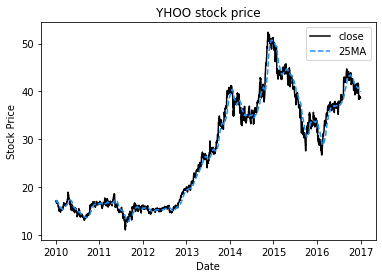

In [52]:
plt.figure()
plt.title("YHOO stock price")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.plot(dataset["date"], dataset["close"], color="black", linestyle="-", label="close")
plt.plot(dataset["date"], dataset["25MA"], color="dodgerblue", linestyle="--", label="25MA")
plt.legend()
plt.show()

In [53]:
ma = dataset["25MA"].values.reshape(-1, 1)
scaler = StandardScaler()
ma_std = scaler.fit_transform(ma)
print(f"ma: {ma[:10]}")
print(f"ma_std: {ma_std[:10]}")

ma: [[17.1       ]
 [17.165     ]
 [17.16666667]
 [17.05000025]
 [16.9800004 ]
 [16.94000033]
 [16.90285743]
 [16.90250025]
 [16.926667  ]
 [16.9160003 ]]
ma_std: [[-0.88504099]
 [-0.87931043]
 [-0.8791635 ]
 [-0.88944909]
 [-0.89562044]
 [-0.89914695]
 [-0.90242155]
 [-0.90245304]
 [-0.90032244]
 [-0.90126285]]


In [54]:
data = []
label = []

for i in range(len(ma_std) - 25):
  data.append(ma_std[i:i + 25])
  label.append(ma_std[i + 25])

data = np.array(data)
label = np.array(label)

data.shape, label.shape

((1737, 25, 1), (1737, 1))

In [55]:
test_len = int(252)
train_len = int(data.shape[0] - test_len)

train_data = data[:train_len]
train_label = label[:train_len]
test_data = data[train_len:]
test_label = data[train_len:]

train_data.shape, test_data.shape, train_label.shape, test_label.shape

((1485, 25, 1), (252, 25, 1), (1485, 1), (252, 25, 1))

In [56]:
train_x = torch.Tensor(train_data)
test_x = torch.Tensor(test_data)
train_y = torch.Tensor(train_label)
test_y = torch.Tensor(test_label)

In [57]:
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

train_batch = DataLoader(
    dataset=train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2
)

test_batch = DataLoader(
    dataset=test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=2
)

for data, label in train_batch:
  print(f"batch data size: {data.size()}")
  print(f"batch label size: {label.size()}")
  break

batch data size: torch.Size([128, 25, 1])
batch label size: torch.Size([128, 1])


## Section 2.3 ニューラルネットワークの定義

In [77]:
class Net(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(D_in, H, batch_first=True,
                            num_layers=1)
        self.linear = nn.Linear(H, D_out)

    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        output = self.linear(output[:, -1, :])  # 最後のステップのみを入力
        return output

In [78]:
D_in = 1
H = 200
D_out = 1
epoch = 100

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [80]:
net = Net(D_in, H, D_out).to(device)
net

Net(
  (lstm): LSTM(1, 200, batch_first=True)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)

## Section 2.4 損失関数と最適化関数の定義

In [81]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

## Section 2.5 学習

In [82]:
train_loss_list = []
test_loss_list = []

for i in range(epoch):
  print("-" * 100)
  print(f"Epoch: {i + 1}/{epoch}")

  train_loss = 0
  test_loss = 0

  # train part
  net.train()
  for data, label in train_batch:
    data = data.to(device)
    label = label.to(device)

    optimizer.zero_grad()
    y_pred = net(data)
    loss = criterion(y_pred, label)
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item()
  batch_train_loss = train_loss / len(train_batch)

  # eval part
  net.eval()
  with torch.no_grad():
    for data, label in test_batch:
      data = data.to(device)
      label = data.to(device)
      
      y_pred = net(data)
      loss = criterion(y_pred.view(1, -1), label)
      test_loss += loss.item()
  batch_test_loss = test_loss / len(test_batch)

  print(f"Train_Loss: {batch_train_loss:.2E}")
  print(f"Test_Loss: {batch_test_loss:.2E}")

  train_loss_list.append(batch_train_loss)
  test_loss_list.append(batch_test_loss)

----------------------------------------------------------------------------------------------------
Epoch: 1/100
Train_Loss: 7.20E-01
Test_Loss: 3.86E-01
----------------------------------------------------------------------------------------------------
Epoch: 2/100


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([128, 25, 1])) that is different to the input size (torch.Size([1, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([124, 25, 1])) that is different to the input size (torch.Size([1, 124])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train_Loss: 9.91E-02
Test_Loss: 9.39E-02
----------------------------------------------------------------------------------------------------
Epoch: 3/100
Train_Loss: 2.57E-02
Test_Loss: 9.98E-02
----------------------------------------------------------------------------------------------------
Epoch: 4/100
Train_Loss: 1.75E-02
Test_Loss: 1.02E-01
----------------------------------------------------------------------------------------------------
Epoch: 5/100
Train_Loss: 1.11E-02
Test_Loss: 1.05E-01
----------------------------------------------------------------------------------------------------
Epoch: 6/100
Train_Loss: 7.11E-03
Test_Loss: 9.92E-02
----------------------------------------------------------------------------------------------------
Epoch: 7/100
Train_Loss: 5.25E-03
Test_Loss: 1.00E-01
----------------------------------------------------------------------------------------------------
Epoch: 8/100
Train_Loss: 4.02E-03
Test_Loss: 1.00E-01
-----------------------------

## Section 2.6 結果の可視化

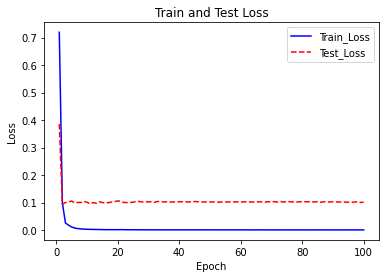

In [83]:
plt.figure()
plt.title('Train and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch + 1), train_loss_list, color="blue", linestyle="-", label="Train_Loss")
plt.plot(range(1, epoch + 1), test_loss_list, color="red", linestyle="--", label="Test_Loss")
plt.legend()
plt.show()

## Section 2.7 テストデータに対する予測の評価

In [105]:
net.eval()
with torch.no_grad():
  pred_ma = []
  true_ma = []
  for data, label in test_batch:
    data = data.to(device)
    label = label.to(device)[:, -1, :]
    y_pred = net(data)
    pred_ma.append(y_pred.view(-1).tolist())
    true_ma.append(label.view(-1).tolist())

In [106]:
pred_ma = [elem for lst in pred_ma for elem in lst]
true_ma = [elem for lst in true_ma for elem in lst]

pred_ma = scaler.inverse_transform(pred_ma)
true_ma = scaler.inverse_transform(true_ma)

In [107]:
mae = mean_absolute_error(true_ma, pred_ma)
mae

0.1240280226639014

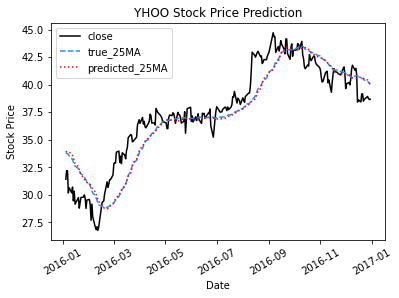

In [109]:
date = dataset["date"][-1 * test_len:]
test_close = dataset["close"][-1 * test_len:].values.reshape(-1)

plt.figure()
plt.title("YHOO Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.plot(date, test_close, color="black", linestyle="-", label="close")
plt.plot(date, true_ma, color="dodgerblue", linestyle="--", label="true_25MA")
plt.plot(date, pred_ma, color="red", linestyle=":", label="predicted_25MA")
plt.legend()
plt.xticks(rotation=30)
plt.show()